In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import utils
from pathlib import Path

2022-02-06 21:43:16.843249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import seaborn as sns
colors = ['#4daf4a', '#e41a1c',  '#377eb8', '#984ea3', '#ff7f00', '#ffff33']
sns.set(font_scale=1.2, style="whitegrid", palette=sns.color_palette(colors))

In [4]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
save_path = project_path+'Outputs/predictions/'

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, recall_score, confusion_matrix, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import time

In [6]:
test_data_path = project_path+'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/'

In [7]:
#ALE
ALE_path = test_data_path+'ALE/'

# if dataset has changed, ALE should be recomputed using the following steps: 1 - create pickles, 2 - aggregate

In [8]:
# import gzip
# import _pickle as pickle
# def create_ALE_pickle(assembly_path):
#     parsed_ale = {}
    
#     with gzip.open(assembly_path, 'rt') as gf: #open
#         cur_contig, cont_length = None, None
#         ti = time.time()
#         for i, g in enumerate(gf):
#             line = g.split()
        
#             if 'Reference' in line[1]:
#                 # Sanity check
#                 if not (cont_length  is None): 
#                     assert((parsed_ale[cur_contig]['depth'] < 10 ** 5).all())
               
#                 cur_contig = line[2]
#                 cont_length = int(line[3])
    
#                 base = 10 ** 5 * np.ones(cont_length)
    
#                 parsed_ale[cur_contig] = {'depth' : base.copy(), 'place' : base.copy(), 
#                                          'insert' : base.copy(), 'kmer' : base.copy()}
    
#                 next(gf)
#                 idx = 0
#                 continue
                
#             if cur_contig is None:
#                 continue
    
#             parsed_ale[cur_contig]['depth'][idx] = float(line[3])
#             parsed_ale[cur_contig]['place'][idx] = float(line[4])
#             parsed_ale[cur_contig]['insert'][idx] = float(line[5])
#             parsed_ale[cur_contig]['kmer'][idx] = float(line[6])
#             idx += 1
            
    
#     save_path = assembly_path.replace('.txt.gz', '_all.pkl') 
#     print (time.time()-ti, save_path)
#     with open(save_path, 'wb') as f:
#         pickle.dump(parsed_ale, f)

In [9]:
# #1.30h
# EXT = ".txt.gz"
# all_txt_files = []
# for r, d, f in os.walk(ALE_path):
#     for file in f:
#         if EXT in file:
#             all_txt_files.append(os.path.join(r,file))

# import pathos
# nprocs = 16
# with pathos.multiprocessing.Pool(nprocs) as pool:
#     pool.map(lambda file: create_ALE_pickle(file), all_txt_files)

In [10]:
# # #synthetic
# def aggregate_ALE(ALE_path):
#     st = time.time()
#     thresh = {'depth': -21,
#               'place' : -2,
#               'insert' : 2,
#               'kmer' : 2}
#     all_preds = {'score':[], 'cont_name':[]}

#     EXT = '.pkl'
#     all_pkl_files = []
#     for r, d, f in os.walk(ALE_path):
#         for file in f:
#             if EXT in file:
#                 all_pkl_files.append(os.path.join(r,file))
    
#     for i, file in enumerate(all_pkl_files): 
#         print(i)
#         with open(file, 'rb') as f:
#             ale_scores = pickle.load(f)
            
#             for cont in ale_scores:
#                 total = 0
#                 for score in ale_scores[cont]:
#                     total += np.sum(ale_scores[cont][score] < thresh[score])
                
#                 all_preds['score'].append(total / float(len(thresh)) / len(ale_scores[cont]['depth']))
#                 all_preds['cont_name'].append('/'.join(file.split('/')[:-1])+'/'+cont)
    
#     ALE_preds = pd.DataFrame.from_dict(all_preds)
#     ALE_preds.to_csv(ALE_path + 'aggregated_preds.csv', index=False) 
#     print('saved as: '+ ALE_path + 'aggregated_preds.csv')
    

    
# aggregate_ALE(ALE_path)

In [11]:
# VALET_path = test_data_path+'VALET/'

In [12]:
# #VALET


# def aggregate_VALET(VALET_path):
#     all_preds = {'score':[], 'cont_name':[]}

#     EXT = '.tsv'
#     all_files = []
#     for r, d, f in os.walk(VALET_path):
#         for file in f:
#             if EXT in file:
#                 all_files.append(os.path.join(r,file))

#     for i, file in enumerate(all_files):
#         print(i)
#         df = pd.read_csv(file, sep='\t')
#         df = df.set_index("contig_name")
#         for cont, pr in df.iterrows():
#             score = np.nan_to_num(pr["low_cov"])+np.nan_to_num(pr["high_cov"])+np.nan_to_num(pr["breakpoints"])
#             all_preds['score'].append(score)
#             all_preds['cont_name'].append('/'.join(file.split('/')[:-1])+'/'+cont)


#     VALET_preds = pd.DataFrame.from_dict(all_preds)
#     VALET_preds.to_csv(VALET_path + 'aggregated_preds.csv', index=False) 
#     print('saved as: '+ VALET_path + 'aggregated_preds.csv')
    
    
# aggregate_VALET(VALET_path)

In [13]:
# VALET_df = pd.read_csv(VALET_path + 'aggregated_preds.csv')

In [14]:
metaMIC_path = test_data_path+'metaMIC/'

In [15]:
# # ### metaMIC

# save_name = 'metaMIC_contig_score.txt.gz'
# files = []
# for r, d, f in os.walk(metaMIC_path):
#     for file in f:
#         if save_name in file:
#             files.append(os.path.join(r, file))
            
# frames = []
# for f in files:
#     cur_df = pd.read_csv(f, sep='\t')
#     f_prefix = '/'.join(f.split('/')[:-2]) + '/'
#     cur_df['cont_name'] = f_prefix + cur_df['contig']
#     frames.append(cur_df)

# metaMIC_preds = pd.concat(frames)
# metaMIC_preds = metaMIC_preds.drop(columns = ['contig', 'length'])
# metaMIC_preds = metaMIC_preds.rename(columns={"metaMIC_contig_score": "metaMIC_score"})
# metaMIC_preds.to_csv(metaMIC_path + 'aggregated_preds.csv', index=False) 
# print('saved as: '+ metaMIC_path + 'aggregated_preds.csv')

In [16]:
deepmased_p1 = pd.read_csv(save_path+'family_test_data_path-v1.csv')
deepmased_p2 = pd.read_csv(save_path+'family_test2-v1.csv')
deepmased_df = pd.concat([deepmased_p1, deepmased_p2])

In [17]:
# resmico_df = pd.read_csv(save_path+'family_test_data_path-mc32_valfixed_666-d02-nblo4.csv')
resmico_df = pd.read_csv(save_path+'0-test-mc40_aucPR_0.727.csv')

ALE_df = pd.read_csv(ALE_path + 'aggregated_preds.csv')
metaMIC_df = pd.read_csv(metaMIC_path + 'aggregated_preds.csv')

In [18]:
#7 parameters are informative
n=7
resmico_df['cont_name']=resmico_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))
ALE_df['cont_name']=ALE_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))
metaMIC_df['cont_name']=metaMIC_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))
# VALET_df['cont_name']=VALET_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))

In [19]:
resmico_df = resmico_df.rename(columns={"score": "resmico_score"})
resmico_df.label = resmico_df.label>0
deepmased_df = deepmased_df.rename(columns={"max": "deepmased_score"})
deepmased_df = deepmased_df.drop(columns = ['label', 'length'])
ALE_df = ALE_df.rename(columns={"score": "ALE_score"})
# VALET_df = VALET_df.rename(columns={"score": "VALET_score"})

In [20]:
len(resmico_df), len(metaMIC_df), len(ALE_df), len(deepmased_df)

(6779977, 2959168, 6785385, 6765625)

In [21]:
result = pd.merge(resmico_df, ALE_df, on=['cont_name'])
print(len(result))
result = pd.merge(result, deepmased_df, on=['cont_name'])
print(len(result))
# result = pd.merge(result, VALET_df, on=['cont_name'])
# print(len(result))
result_m = pd.merge(result, metaMIC_df, on=['cont_name'])
print(len(result_m))

6569643
6412977
2756991


In [22]:
len(set(resmico_df.cont_name) - set(ALE_df.cont_name))

210334

In [23]:
len(set(ALE_df.cont_name) - set(resmico_df.cont_name))

215742

In [24]:
y_true_r, y_resmico = resmico_df.label, resmico_df.resmico_score

# resmico
prs, rcs, thresholds = precision_recall_curve(y_true_r, y_resmico)

thr = 0.9
ind = np.argmin(np.abs(thresholds-thr))
precision = prs[ind]
recall = rcs[ind]

print('thr: {}, recall: {:.2f}, precision: {:.2f}'.format(thr, recall, precision))

thr: 0.9, recall: 0.49, precision: 0.85


In [25]:
np.sum(resmico_df.resmico_score>0.9)/len(resmico_df.label)

0.0234161561315031

## Performance comparison with baselines

In [26]:
def PR4all(axs, i, df, df_m,
           dataset_name = 'dname', save_path=None):
    if i==-1:
        ax=axs
    else:
        ax = axs[i]
    y_true_r, y_resmico = df.label, df.resmico_score
    y_true_d, y_deepmased = df.label, df.deepmased_score
    y_true_a, y_ALE = df.label, df.ALE_score
    y_true_m, y_metaMIC = df_m.label, df_m.metaMIC_score
    
#     colors = [(0, 160/255, 81/255), (28/255, 117/255, 188/255), (46/255, 49/255, 14/255), (236/255, 0, 140/255)]
    linestyles = ['solid','dashed']
    colors = ['#4daf4a', '#e41a1c',  '#377eb8', '#984ea3', '#ff7f00', '#ffff33']

    # resmico
    prs, rcs, thresholds = precision_recall_curve(y_true_r, y_resmico)
    re = ax.plot(rcs, prs, lw=1.5, color=colors[0], ls=linestyles[0],
                 label='ResMiCo: %0.3f' % (average_precision_score(y_true_r, y_resmico)))

    # metaMIC
    prs, rcs, thresholds = precision_recall_curve(y_true_m, y_metaMIC)
    m = ax.plot(rcs, prs, lw=1.5, color=colors[1], ls=linestyles[0],
                 label='metaMIC: %0.3f' % (average_precision_score(y_true_m, y_metaMIC)))
    # deepmased
    prs, rcs, thresholds = precision_recall_curve(y_true_d, y_deepmased)
    d = ax.plot(rcs, prs, lw=1.5, color=colors[2], ls=linestyles[0],
                 label='DeepMAsED: %0.3f' % (average_precision_score(y_true_d, y_deepmased)))
        
    # ALE
    prs, rcs, thresholds = precision_recall_curve(y_true_a, y_ALE)
    a =ax.plot(rcs, prs, lw=1.5, color=colors[3], ls=linestyles[0],
                 label='ALE: %0.3f' % (average_precision_score(y_true_a, y_ALE)))
    
        
    # Random
    pr_random = np.mean(y_true_r)
    ra = ax.plot([0, 1], [pr_random, pr_random], color='black', ls=linestyles[1], label="Random: %0.3f" % pr_random, lw=2)


#     ax.tick_params(axis='both', which='major') #, labelsize=12
#     ax.set_ylim([0.0, 1.0])
#     ax.set_xlim([0.0, 1.0])
    
    # plt.title('Receiver operating characteristic example')
#     if i==1:
#         ax.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', 
#                   ncol=5, fontsize=26)
    
    ax.set_ylabel('Precision') #, fontsize=16
    ax.set_xlabel('Recall')
    
    ax.legend(bbox_to_anchor=(0.6, 1.0), loc='upper left') #
#     ax.grid(True, axis='y', linestyle=':')
#     ax.grid(True, axis='x', linestyle=':')
    
#     ax.set_title('skin', fontsize=16)

    return 

In [27]:
print('metamic subset:')
print('AUPRC metaMIC: ',
      average_precision_score(result_m['label']>0, result_m['metaMIC_score']))
print('AUPRC resmico_score: ',
  average_precision_score(result_m['label']>0, result_m['resmico_score']))
print('AUPRC deepmased_score: ',
  average_precision_score(result_m['label']>0, result_m['deepmased_score']))
print('AUPRC ALE_score: ',
      average_precision_score(result_m['label']>0, result_m['ALE_score']))
print('RANDOME score: ',
      np.mean(result_m['label']))
print('')
print('AUROC metaMIC: ',
      roc_auc_score(result_m['label']>0, result_m['metaMIC_score']))
print('AUROC resmico_score: ',
  roc_auc_score(result_m['label']>0, result_m['resmico_score']))
print('AUROC deepmased_score: ',
  roc_auc_score(result_m['label']>0, result_m['deepmased_score']))
print('AUROC ALE_score: ',
      roc_auc_score(result_m['label']>0, result_m['ALE_score']))

metamic subset:
AUPRC metaMIC:  0.09506335543987997
AUPRC resmico_score:  0.5540088553409042
AUPRC deepmased_score:  0.07832596960406266
AUPRC ALE_score:  0.04697497018824034
RANDOME score:  0.02676251028748371

AUROC metaMIC:  0.7861088530536634
AUROC resmico_score:  0.9612832037441907
AUROC deepmased_score:  0.6564560532192175
AUROC ALE_score:  0.6132890424621857


In [28]:
print('combined 3 methods: ')

print('AUPRC resmico_score: ',
  average_precision_score(result['label']>0, result['resmico_score']))
print('AUPRC deepmased_score: ',
  average_precision_score(result['label']>0, result['deepmased_score']))
print('AUPRC ALE_score: ',
      average_precision_score(result['label']>0, result['ALE_score']))
print('RANDOME score: ',
      np.mean(result['label']))

print('')
print('AUROC resmico_score: ',
  roc_auc_score(result['label']>0, result['resmico_score']))
print('AUROC deepmased_score: ',
  roc_auc_score(result['label']>0, result['deepmased_score']))
print('AUROC ALE_score: ',
      roc_auc_score(result['label']>0, result['ALE_score']))

combined 3 methods: 
AUPRC resmico_score:  0.7523310229041367
AUPRC deepmased_score:  0.25068800640568456
AUPRC ALE_score:  0.08000306999021123
RANDOME score:  0.04018383349885708

AUROC resmico_score:  0.9724515839969118
AUROC deepmased_score:  0.7733366331484038
AUROC ALE_score:  0.6700899215125493


/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality//Outputs/figures/PRcurve_n9knovel.pdf


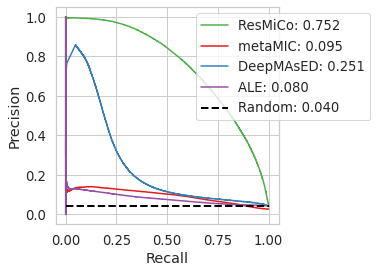

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))


PR4all(axs, -1,  result, result_m)


where = project_path+'/Outputs/figures/PRcurve_n9knovel.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

plt.show()

## Performance for different length

In [30]:
df_all_preds = resmico_df

In [31]:
bin_names = ['1k-2k', '2k-3k', '3k-4k', '4k-5k', '5k-6k', '6k-7k', '7k-10k', '10k-20k', '20k-50k', '>50k']
min_max_len = [(1000, 2000), (2000, 3000), (3000, 4000),
               (4000, 5000), (5000, 6000), (6000, 7000),
               (7000, 10000), (10000, 20000), 
               (20000, 50000), (50000, 10000000)]

bin_n = []
bin_avglabel = []
bin_prauc = []
bin_roc = []
bin_errorrate = []

for minl, maxl in min_max_len:
    temp_df = df_all_preds[(df_all_preds.length>=minl)&(df_all_preds.length<maxl)]
    bin_n.append(temp_df.shape[0])
    bin_avglabel.append(temp_df['label'].mean())
    
    pr_auc = average_precision_score(temp_df['label'], temp_df['resmico_score'])
    bin_prauc.append(pr_auc)
    bin_roc.append(roc_auc_score(temp_df['label'], temp_df['resmico_score']))
    
    bin_errorrate.append(sum(temp_df.resmico_score>0.5)/sum(temp_df.label))
    
    print(minl, maxl)
    precision, recall, thresholds = precision_recall_curve(temp_df['label'], temp_df['resmico_score'])
#     arg_r50 = np.argmin(np.abs(recall-0.5))
#     print('set50: recall: {:.3f}, precision {:.3f}, threshold {:.3f}'.format(
#         recall[arg_r50], precision[arg_r50], thresholds[arg_r50]))
#     arg_r90 = np.argmin(np.abs(recall-0.90))
#     print('set90: recall: {:.3f}, precision {:.3f}, threshold {:.3f}'.format(
#         recall[arg_r90], precision[arg_r90], thresholds[arg_r90]))
    print('')
    arg_th = np.argmin(np.abs(thresholds-0.5)) #0.8 on total recall
    print('set thr: recall: {:.3f}, precision {:.3f}, threshold {:.3f}'.format(
        recall[arg_th], precision[arg_th], thresholds[arg_th]))
    print('')

1000 2000

set thr: recall: 0.833, precision 0.539, threshold 0.500

2000 3000

set thr: recall: 0.768, precision 0.478, threshold 0.500

3000 4000

set thr: recall: 0.708, precision 0.449, threshold 0.500

4000 5000

set thr: recall: 0.649, precision 0.407, threshold 0.500

5000 6000

set thr: recall: 0.603, precision 0.394, threshold 0.500

6000 7000

set thr: recall: 0.573, precision 0.389, threshold 0.500

7000 10000

set thr: recall: 0.530, precision 0.420, threshold 0.500

10000 20000

set thr: recall: 0.605, precision 0.291, threshold 0.500

20000 50000

set thr: recall: 0.640, precision 0.284, threshold 0.500

50000 10000000

set thr: recall: 0.700, precision 0.290, threshold 0.500



In [32]:
def autolabel(rects):
    """Attach a text label above bar."""
    i=0
    for rect1 in rects:
        height = rect1.get_height()
        ax.annotate('{:.2f}'.format(bin_avglabel[i]),
                    xy=(rect1.get_x() + rect1.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
                    ha='center', va='bottom')
        i+=1

In [33]:
def autolabel(bar_plot):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bin_names[idx],
                ha='center', va='bottom', rotation=0)


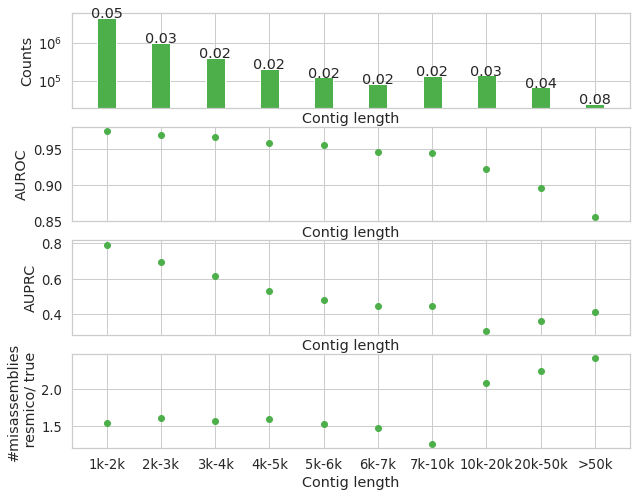

In [34]:
fig, axs = plt.subplots(4, 1, figsize=(10,8), sharex=True)
width = 0.35
positions = np.arange(len(bin_names))

#0
p1 = axs[0].bar(positions, bin_n, width)
axs[0].set_xticks(positions)
axs[0].set_xticklabels(bin_names)

for i, p in enumerate(p1):
    height = p.get_height()
    axs[0].text(x=p.get_x() + p.get_width() / 2, y=height+.10,
    s="{:.2f}".format(bin_avglabel[i]),
    ha='center')
    
axs[0].set_yscale('log')
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Contig length')

#1
axs[1].scatter(positions, bin_roc)
axs[1].set_xticks(positions)
axs[1].set_xticklabels(bin_names)
# axs[1].set_yticks(np.arange(0.8, 1.1, .2))
axs[1].set_ylabel('AUROC')
axs[1].set_xlabel('Contig length')

#2
axs[2].scatter(positions, bin_prauc)
axs[2].set_xticks(positions)
axs[2].set_xticklabels(bin_names)
# axs[2].set_yticks(np.arange(0, 1, 0.5))
axs[2].set_ylabel('AUPRC')
axs[2].set_xlabel('Contig length')

#3
axs[3].scatter(positions, bin_errorrate)
axs[3].set_xticks(positions)
axs[3].set_xticklabels(bin_names)
axs[3].set_ylabel('#misassemblies\n resmico/ true')
axs[3].set_xlabel('Contig length')
axs[3].grid(True)



where = project_path+'/Outputs/figures/binned_length.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)

plt.show()

## Performance parameters

In [35]:
df_all_preds = resmico_df

In [36]:
split_name = df_all_preds['cont_name'].str.split('/', expand = True)
cols = ['richness', 'abund_dist', 'sim_rep', 'read_length', 'seq_depth', 'assembler', 'cont']

In [37]:
for i, col in enumerate(cols):
    df_all_preds[col] = split_name[i]

In [38]:
def auroc_group(df):
    return roc_auc_score(df.label, df.resmico_score)

def auprc_group(df):
    return average_precision_score(df.label, df.resmico_score)

def errorrate_group(df):
    return sum(df.resmico_score>0.5)/sum(df.label)

In [39]:
grouped = df_all_preds.groupby(['richness', 'abund_dist', 'read_length', 'seq_depth', 'assembler'],
                               as_index=False).apply(
    lambda x: pd.Series({'#misassemblies\n resmico/ true':errorrate_group(x)})).reset_index(drop=True)
grouped[['richness', 'seq_depth']] = grouped[['richness', 'seq_depth']].apply(pd.to_numeric)

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/paramgrid_errorrate_family.pdf


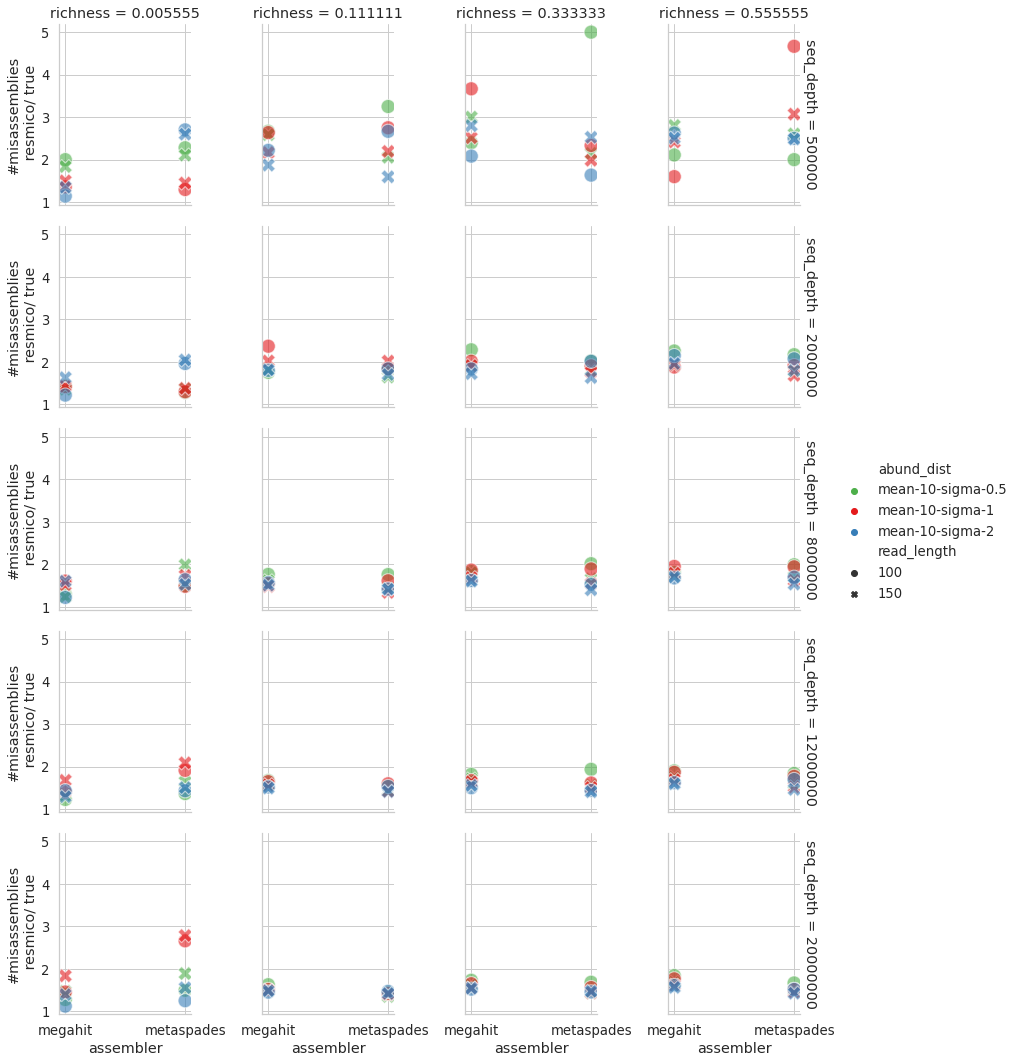

In [40]:
g = sns.FacetGrid(grouped, col="richness", row='seq_depth',
                  margin_titles=True)
g.map_dataframe(sns.scatterplot, x="assembler", y='#misassemblies\n resmico/ true', 
                style='read_length', hue='abund_dist', 
                s=200, alpha=0.6)
g.tight_layout()
g.add_legend()

dataset_name = 'family'
where = project_path+'Outputs/figures/paramgrid_errorrate_'+dataset_name+'.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

In [41]:
grouped = df_all_preds.groupby(['richness', 'abund_dist', 'read_length', 'seq_depth', 'assembler'],
                               as_index=False
                              ).apply(lambda x: pd.Series({'AUPRC':auprc_group(x)})).reset_index(drop=True)
grouped[['richness', 'seq_depth']] = grouped[['richness', 'seq_depth']].apply(pd.to_numeric)

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/paramgrid_auprc_family.pdf


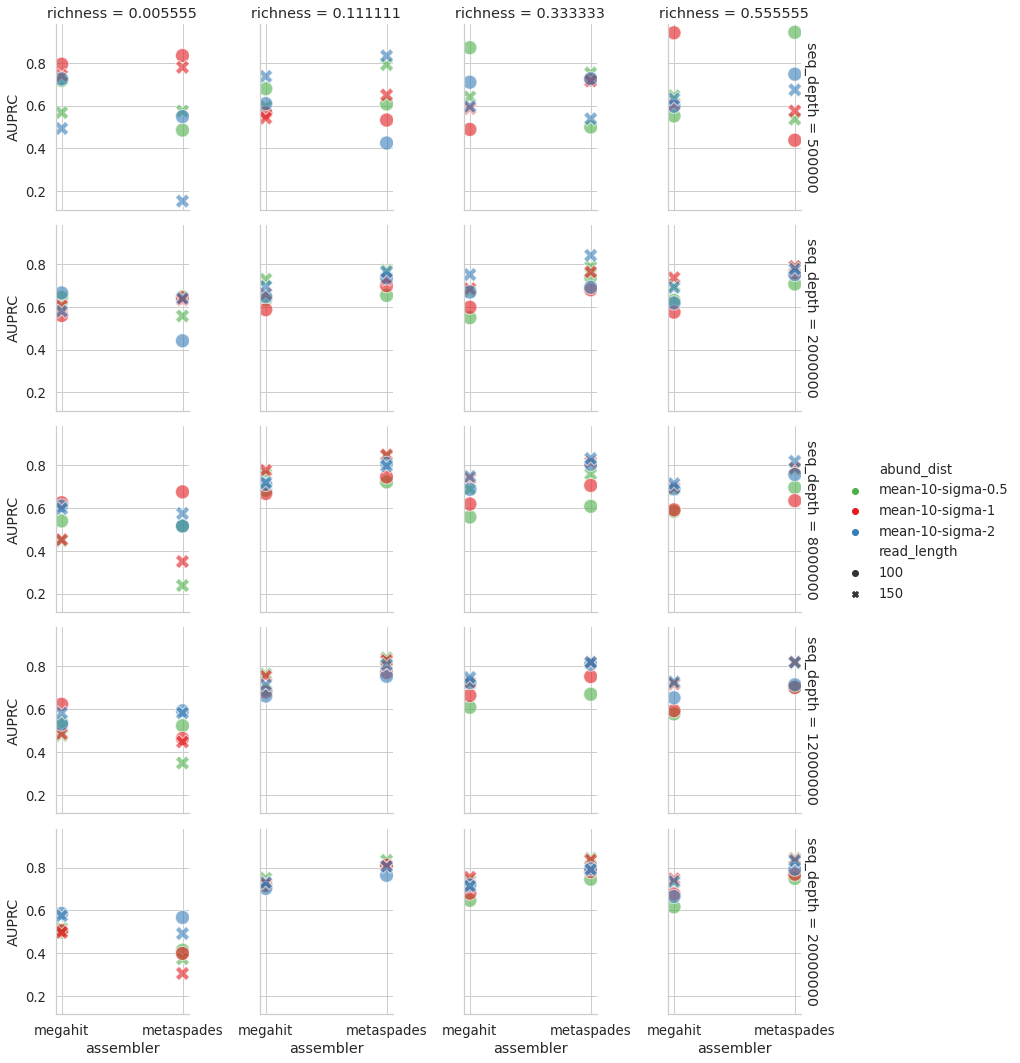

In [42]:
g = sns.FacetGrid(grouped, col="richness", row='seq_depth',
                  margin_titles=True)
g.map_dataframe(sns.scatterplot, x="assembler", y="AUPRC", style='read_length', hue='abund_dist', 
                s=200, alpha=0.6)
g.tight_layout()
g.add_legend()

dataset_name = 'family'
where = project_path+'Outputs/figures/paramgrid_auprc_'+dataset_name+'.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

In [43]:
grouped = df_all_preds.groupby(['richness', 'abund_dist', 'read_length', 'seq_depth', 'assembler'],
                               as_index=False
                              ).apply(lambda x: pd.Series({'AUROC':auroc_group(x)})).reset_index(drop=True)
grouped[['richness', 'seq_depth']] = grouped[['richness', 'seq_depth']].apply(pd.to_numeric)

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/paramgrid_auroc_family.pdf


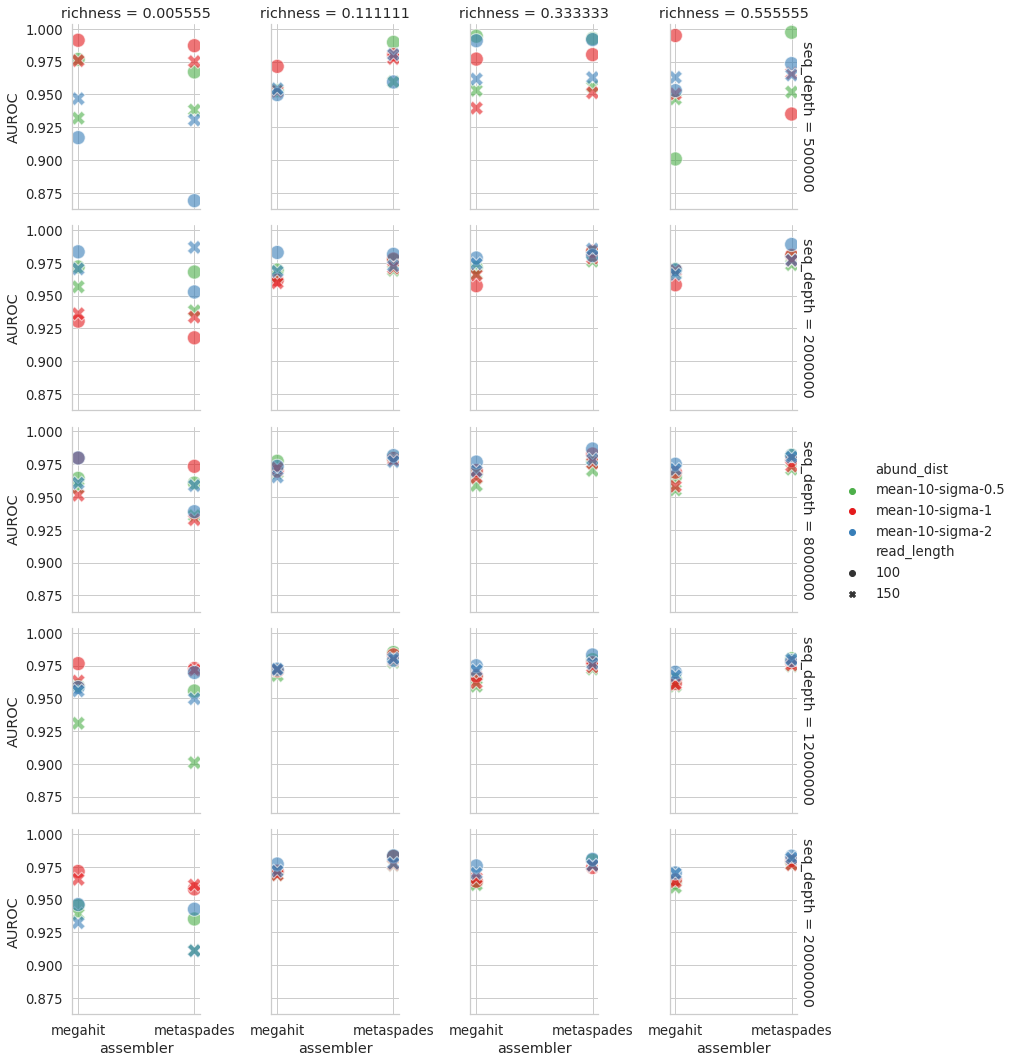

In [44]:
g = sns.FacetGrid(grouped, col="richness", row='seq_depth',
                  margin_titles=True)
g.map_dataframe(sns.scatterplot, x="assembler", y="AUROC", style='read_length', hue='abund_dist', 
                s=200, alpha=0.6)
g.tight_layout()
g.add_legend()

dataset_name = 'family'
where = project_path+'Outputs/figures/paramgrid_auroc_'+dataset_name+'.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

## Metrics after filtering misassemblies

In [45]:
def calculate_N50(list_of_lengths):
    numlist = np.array(list_of_lengths)
    numlist.sort()
    newlist = []
    for x in numlist :
        newlist += [x]*x
    # take the mean of the two middle elements if there are an even number
    # of elements. otherwise, take the middle element
    if len(newlist) % 2 == 0:
        medianpos = int(len(newlist)/2)

        return float(newlist[medianpos-1] + newlist[medianpos]) /2
    else:
        medianpos = int(np.ceil(len(newlist)/2))

        return newlist[medianpos-1]


In [46]:
print('Original')
print('true error rate {:.3f}'.format(df_all_preds.label.mean()))
print('N contigs {:d}'.format(df_all_preds.shape[0]))
print('Mean length {:.0f}'.format(df_all_preds.length.mean()))
print('Median length {:.0f}'.format(df_all_preds.length.median()))
print('')

df_filtered = df_all_preds[df_all_preds.resmico_score<0.5]
print('ResMiCo')
print('true error rate {:.3f}'.format(df_filtered.label.mean()))
print('N contigs {:d}'.format(df_filtered.shape[0]))
print('Mean length {:.0f}'.format(df_filtered.length.mean()))
print('Median length {:.0f}'.format(df_filtered.length.median()))
print('')

Original
true error rate 0.040
N contigs 6779977
Mean length 2911
Median length 1510

ResMiCo
true error rate 0.008
N contigs 6351428
Mean length 2849
Median length 1522



In [47]:
#run this only if enough memory reqquested
calculate_N50(df_all_preds.length), calculate_N50(df_filtered.length)

(3919.0, 3726)